In [125]:
from glob import glob
import os
from os.path import basename, splitext
import pandas as pd
from datetime import datetime
from pytz import timezone
import shapefile
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [126]:
# parameters
sf_path = "data/points_akl.shp"
data_dir="results"
tz = timezone("Pacific/Auckland")

In [127]:
# data loading and sanity checking

# shapefile
points = shapefile.Reader(sf_path)
npt = len(points.records())
print(f"Loaded shapefile with {npt} points")

# odt spatial index
geoids = sorted([r[0] for r in points.records()])
loc_idx = {g:i for i, g in enumerate(geoids)}
assert len(loc_idx) == npt, "Shapefile may contain duplicate identifiers"

file_paths = glob(os.path.join(data_dir, "*.csv"))
nf = len(file_paths)
                                  
# generate time index
query_times = [splitext(basename(f))[0] for f in file_paths]
query_times = [datetime(*map(int, t.split('_')[1:])) for t in query_times]
query_times = sorted(set(query_times))
t_idx = {t:i for i, t in enumerate(sorted(set(query_times)))}
nt = len(t_idx)
assert nf == nt * npt, f"Number of result files {nf} should equal the number of time indices '{nt}' times number of points '{npt}'"

print(f"Found {nf} files representing {npt} points at {nt} time slices")
print(f"Estimated cube size {nt * npt * npt * 32 / (1024 ** 2):.1f} MiB")

Loaded shapefile with 2011 points
Found 4022 files representing 2011 points at 2 time slices
Estimated cube size 246.8 MiB


In [128]:
def load_result(file_path):
           
    # process filename
    bn = os.path.basename(file_path)
    tokens = os.path.splitext(bn)[0].split("_")
    geoid, Y, M, D, h, m, s = map(int, tokens)
    dt = datetime(Y, M, D, h, m, s,)
    
    # read csv data intof dataframe
    df = pd.read_csv(file_path, parse_dates=["queryTime"], infer_datetime_format=True) 
    
    return geoid, dt, df

In [129]:
odt = np.ones((npt, npt, nt), dtype=np.float32) * -10
for i, f in enumerate(file_paths):
    geoid, dt, df = load_result(f)
    o = loc_idx[geoid]
    d = [loc_idx[p] for p in df.toPlace]
    t = t_idx[dt]
    odt[o, d, t] = df.eta     
    print(f"loading data {100 * (i+1)/nf:.1f} %", end='\r')

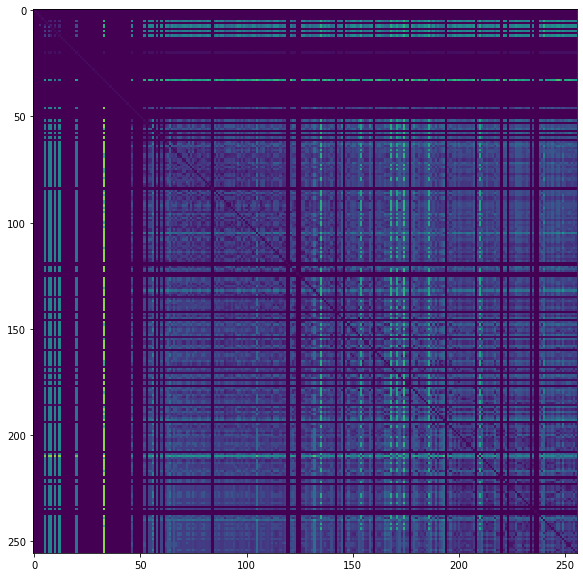

In [130]:
plt.figure(figsize=(10, 10))
plt.imshow(odt[:256, :256, 0]/odt.max())
plt.show()

In [96]:
odt.max()

546.6